In [1]:
import numpy as np
import matplotlib.pyplot as plt

from autoencoder_utils import read_payri_images

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
PAPYRI_BASE= '../../Datasets/alpub_v2/papyri_images/seg_mask_otsu_256_200'

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [4]:
torch.cuda.empty_cache()

In [5]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# Define transformations to be applied to the images (if needed)
# You can customize these transformations based on your specific requirements
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a fixed size (e.g., 256x256)
    transforms.Grayscale(), # Greyscale the images
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
])

# Create the ImageFolder dataset
dataset = ImageFolder(root=PAPYRI_BASE, transform=transform)

# Define the ratio of data to be used for training, validation, and testing
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate the number of samples for each set based on the ratios
num_samples = len(dataset)
num_train_samples = int(train_ratio * num_samples)
num_val_samples = int(val_ratio * num_samples)
num_test_samples = num_samples - num_train_samples - num_val_samples

# Use random_split to split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(dataset, [num_train_samples, num_val_samples, num_test_samples])

# Create the DataLoaders for each set
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [7]:
# Assuming you have already created the DataLoader (train_loader, val_loader, or test_loader)

# Get the number of batches in the DataLoader
num_batches = len(train_loader)  # Change 'train_loader' to 'val_loader' or 'test_loader' as needed

# Get the batch size used in the DataLoader
batch_size = train_loader.batch_size  # Change 'train_loader' to 'val_loader' or 'test_loader' as needed

# Calculate the total number of samples in the DataLoader
total_samples = num_batches * batch_size

print("Number of batches:", num_batches)
print("Batch size:", batch_size)
print("Total number of samples:", total_samples)

Number of batches: 2177
Batch size: 16
Total number of samples: 34832


In [8]:
#UNet Implementation

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset, Subset

In [9]:
#Simple UNet Model without skip connections. Works with 256x256 image size

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),#256x256x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #256x256x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #128x128x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),#128x128x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #128x128x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#32x32x128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #32x32x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#16x16x256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #16x16x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #8x8x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#8x8x512
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #8x8x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #4x4x512
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #4x4x512
            nn.Upsample(scale_factor=2),#8x8x512
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), #8x8x256
            nn.Upsample(scale_factor=2),#16x16x256
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),#16x16x128
            nn.Upsample(scale_factor=2),#32x32x128
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),#32x32x64
            nn.Upsample(scale_factor=2), #64x64x64
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#64x64x32
            nn.Upsample(scale_factor=2), #128x128x32
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),#128x128x16
            nn.Upsample(scale_factor=2), #256x256x16
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1), #256x256x1
            nn.Sigmoid()
        )

    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

In [11]:
model = UNetWithoutSkipConnections(in_channels=1, out_channels=1, dropout_prob=0.1)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
batch_size = 16

best_test_loss = float('inf')
best_model_state = None

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels = batch

        # Forward pass
        reconstructions = model(images.to(device))
        loss = criterion(reconstructions, images.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images.to(device))
            loss = criterion(reconstructions, images.to(device))

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/papyri_autoencoder_256_upsample_u_net_greyscale_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

Epoch 0 Processing Batch No: 1
Epoch 0 Processing Batch No: 2
Epoch 0 Processing Batch No: 3
Epoch 0 Processing Batch No: 4
Epoch 0 Processing Batch No: 5
Epoch 0 Processing Batch No: 6
Epoch 0 Processing Batch No: 7
Epoch 0 Processing Batch No: 8
Epoch 0 Processing Batch No: 9
Epoch 0 Processing Batch No: 10
Epoch 0 Processing Batch No: 11
Epoch 0 Processing Batch No: 12


KeyboardInterrupt: 

In [74]:
test_loader = DataLoader(Subset(test_set,range(50)), batch_size=1, shuffle=False, pin_memory=True)

In [75]:
model = torch.load('../models/papyri_autoencoder_256_upsample_u_net_middle_layer_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')
# Set the model to evaluation mode
model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in test_loader:

        images, labels = batch

        # Perform inference
        outputs = model(images.to(device))

        results_test.append(images)
        results_test.append(outputs)

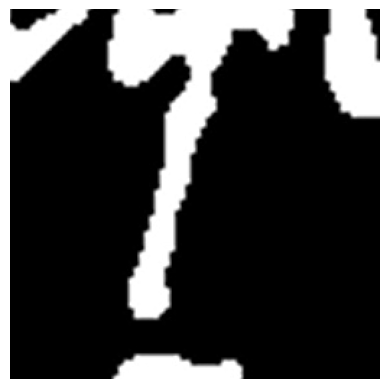

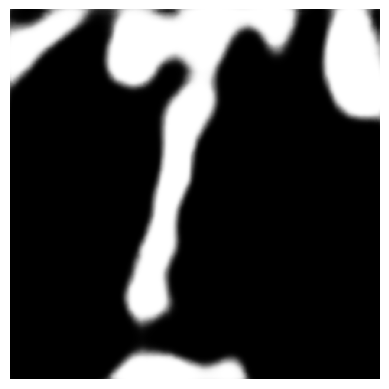

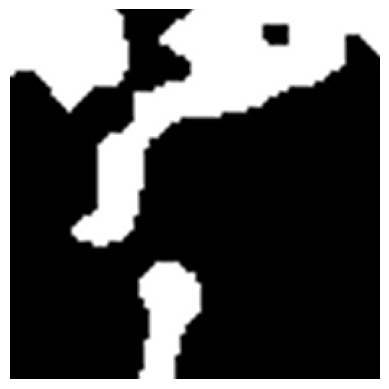

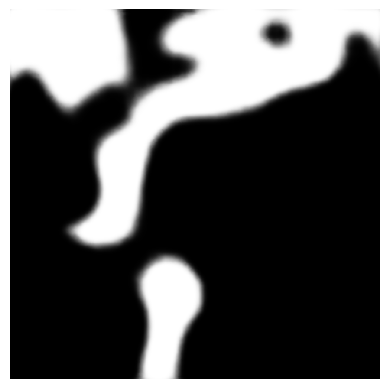

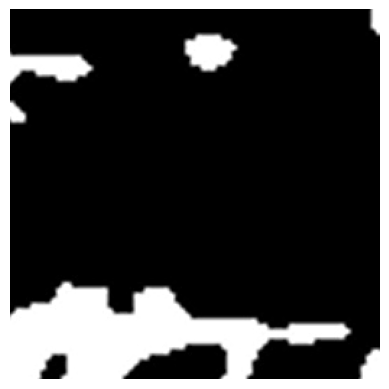

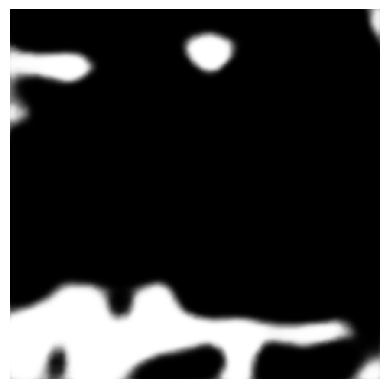

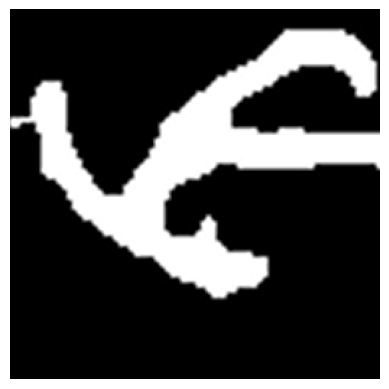

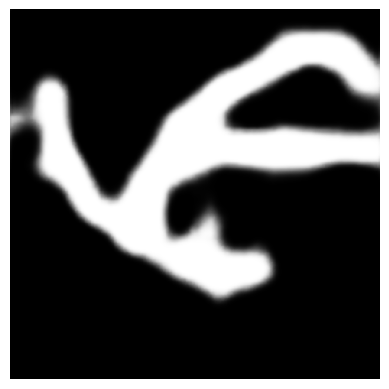

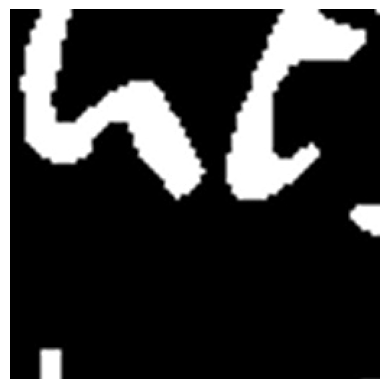

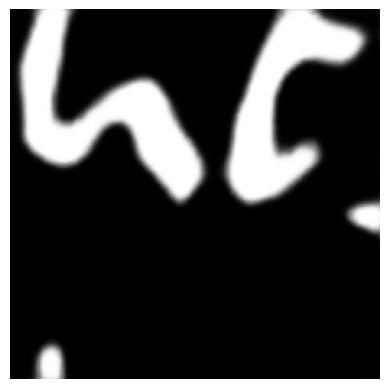

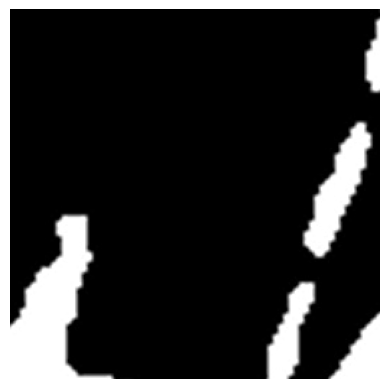

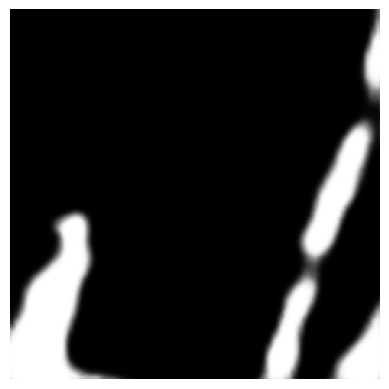

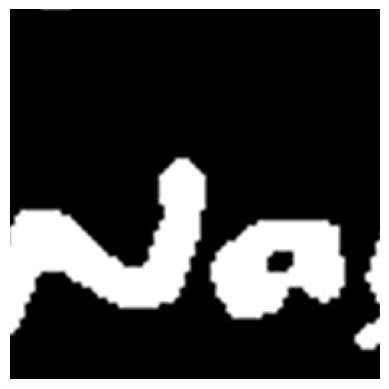

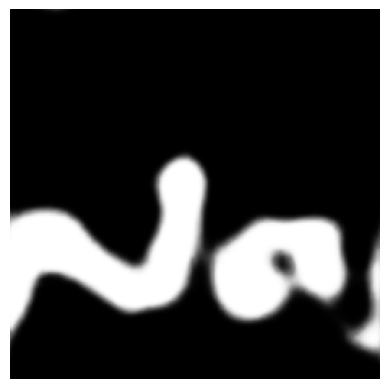

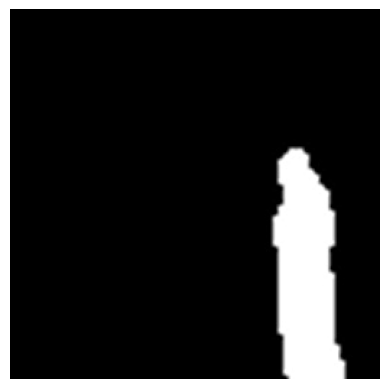

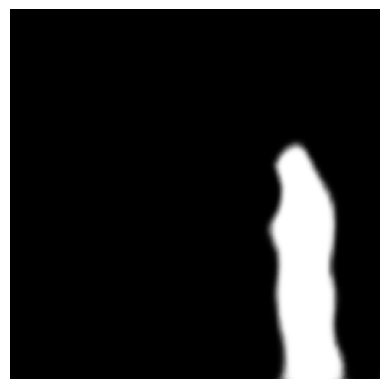

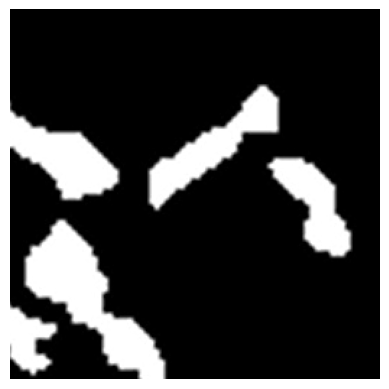

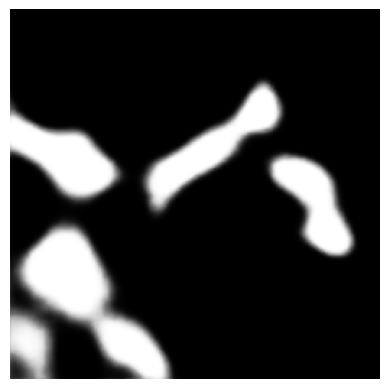

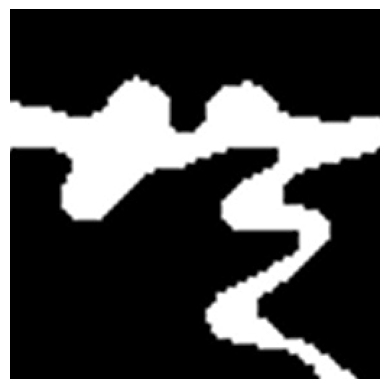

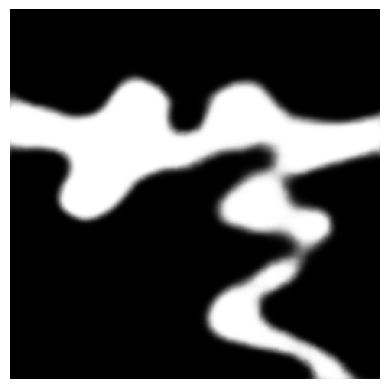

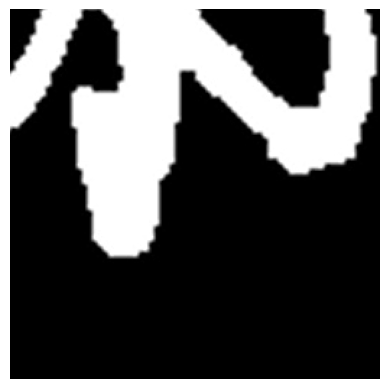

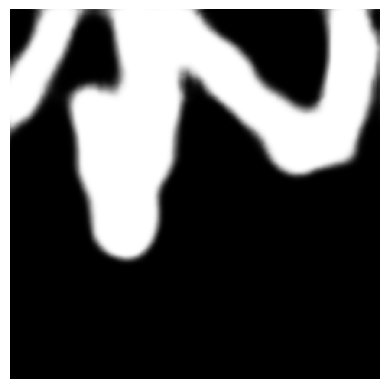

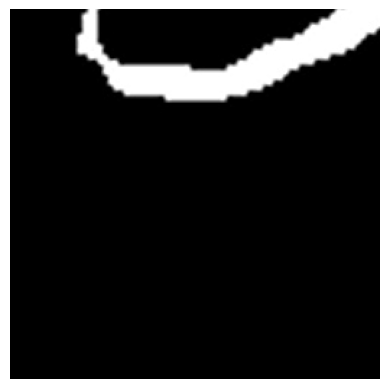

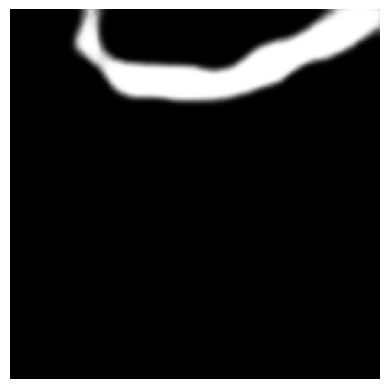

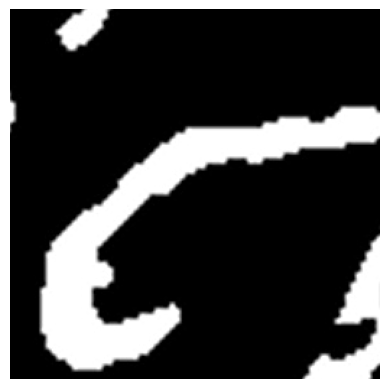

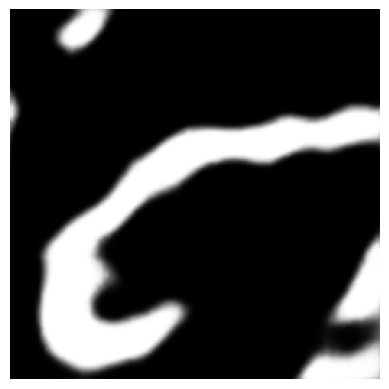

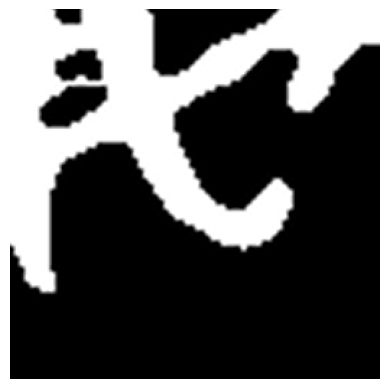

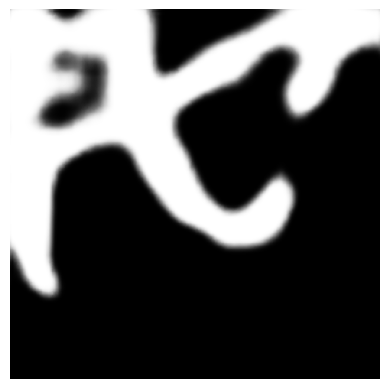

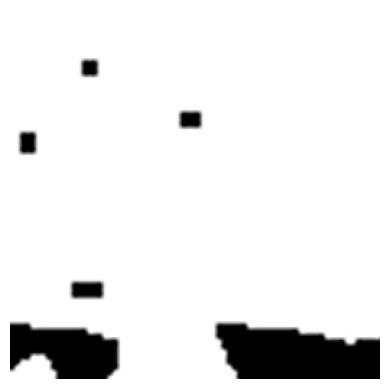

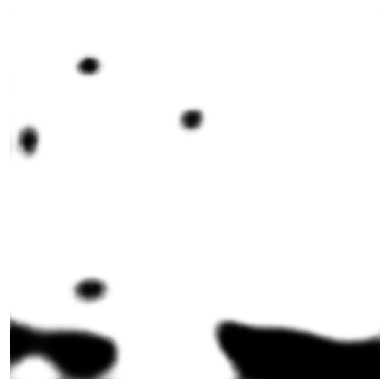

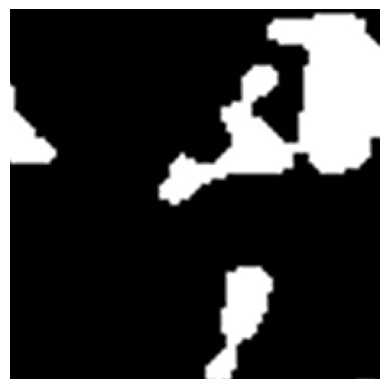

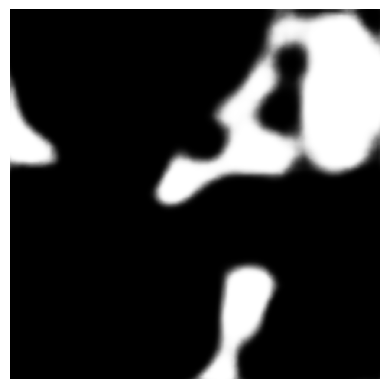

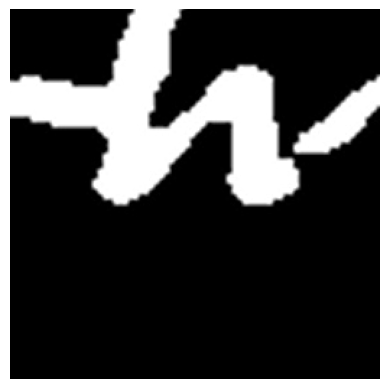

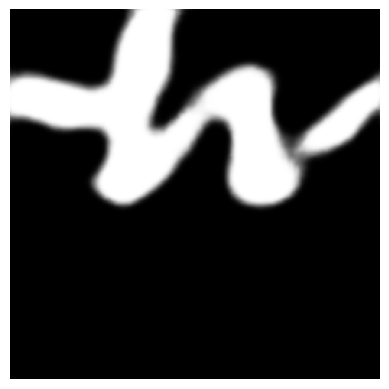

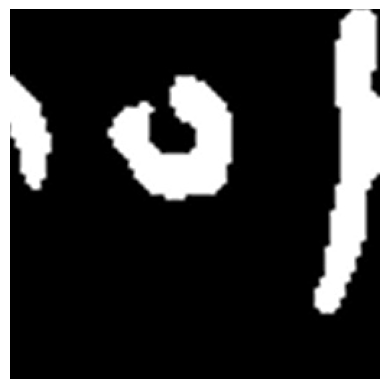

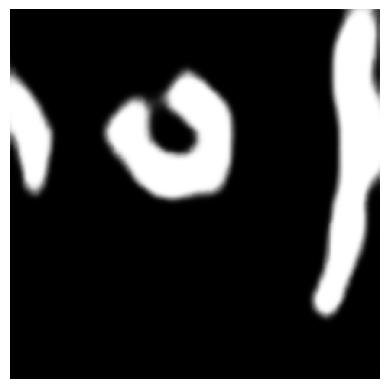

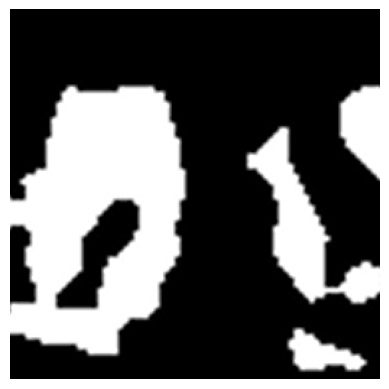

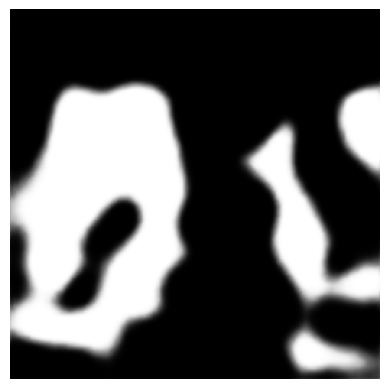

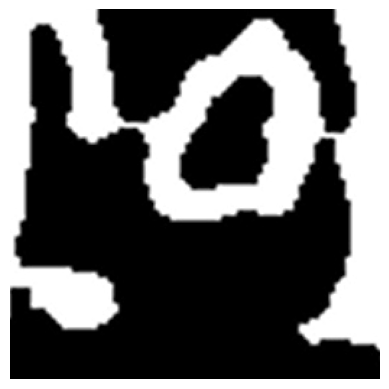

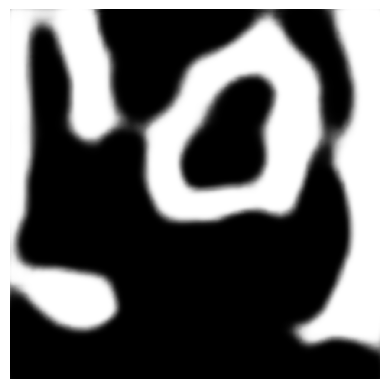

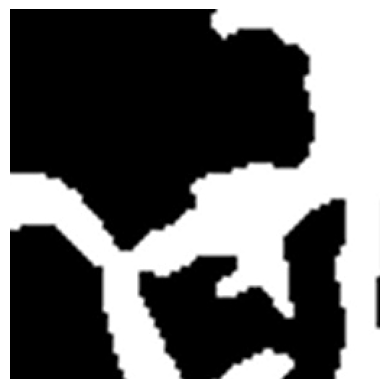

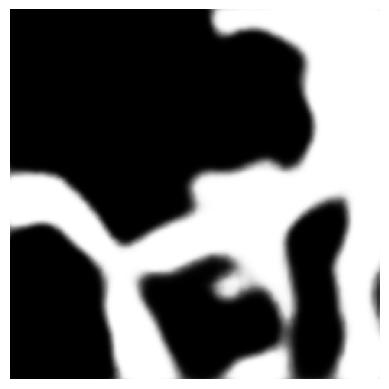

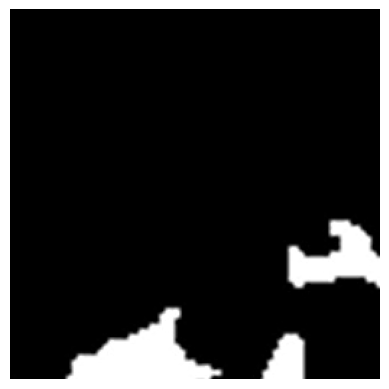

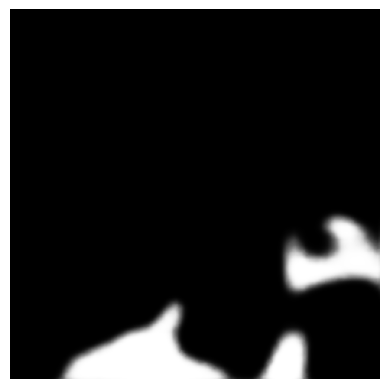

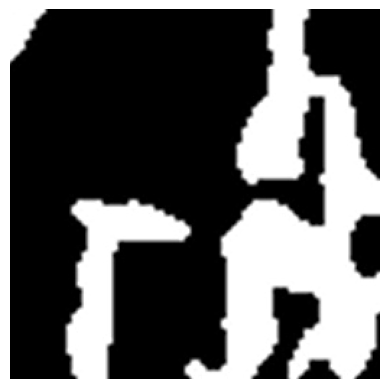

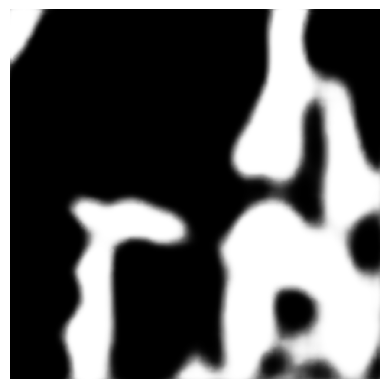

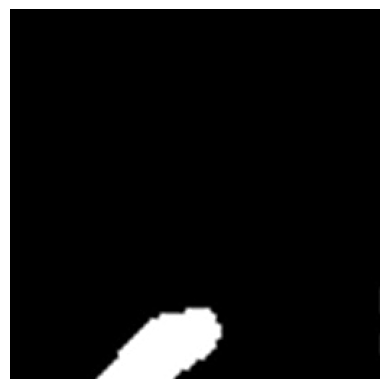

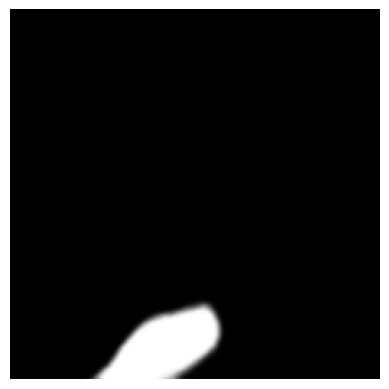

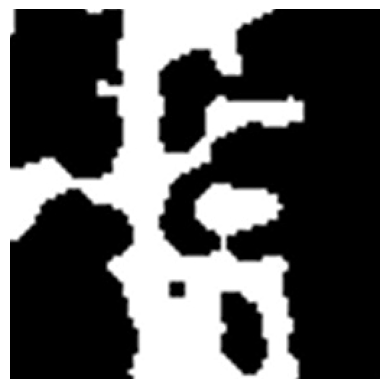

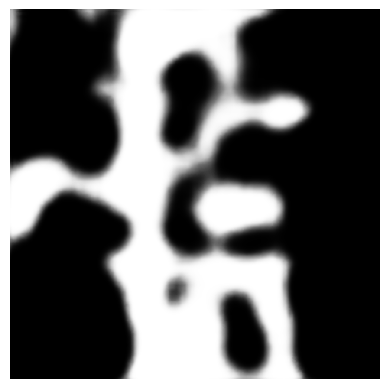

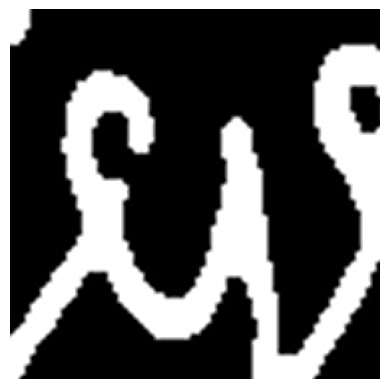

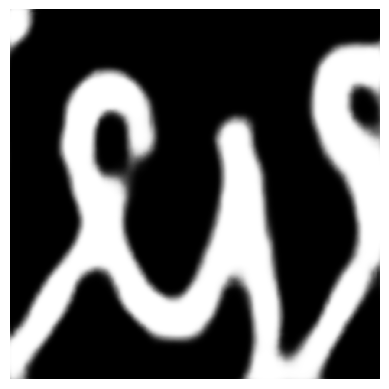

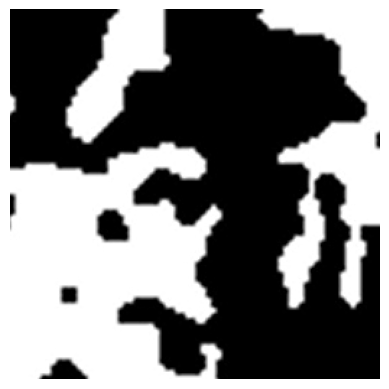

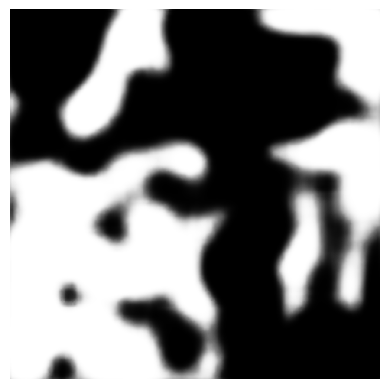

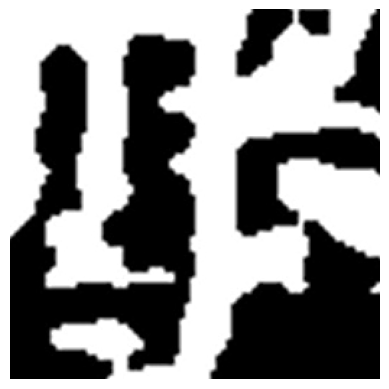

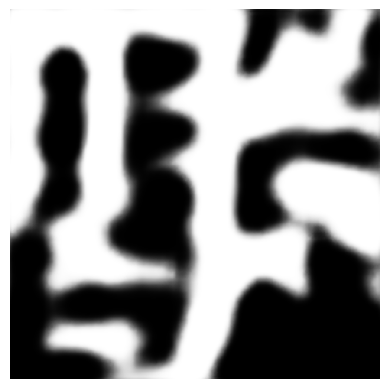

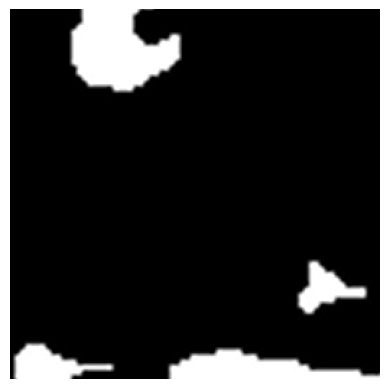

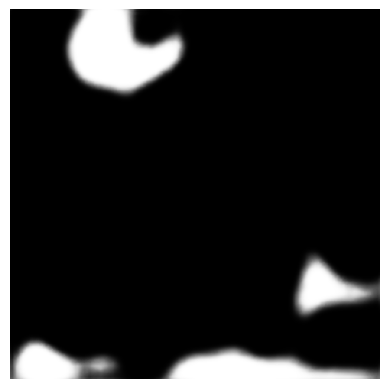

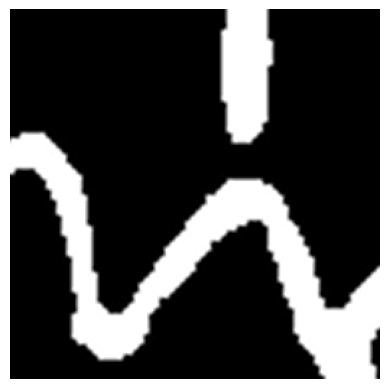

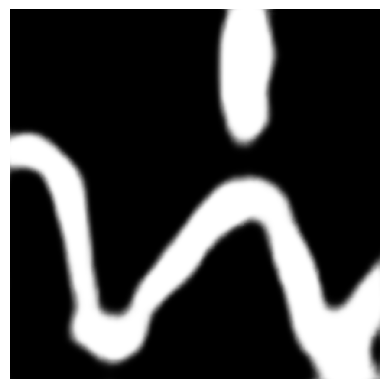

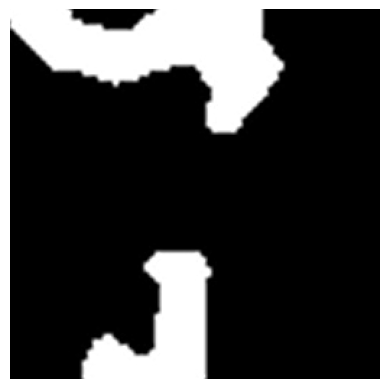

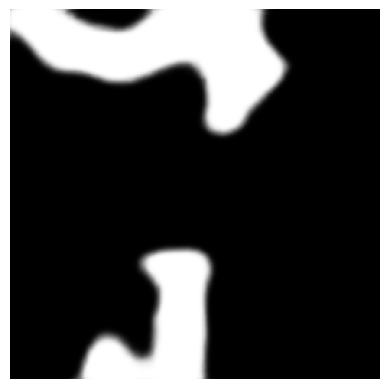

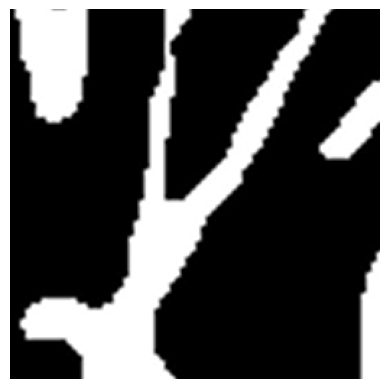

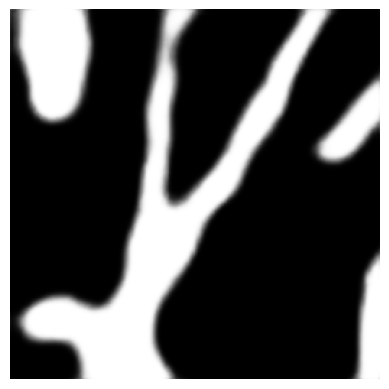

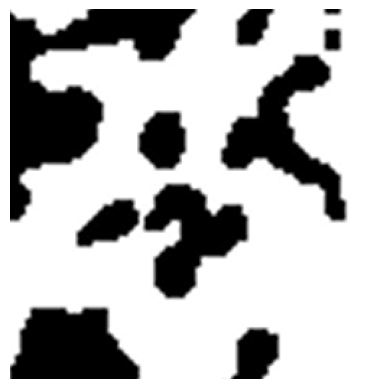

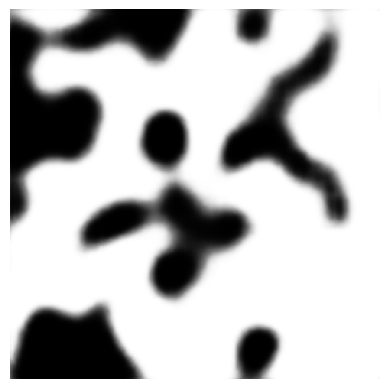

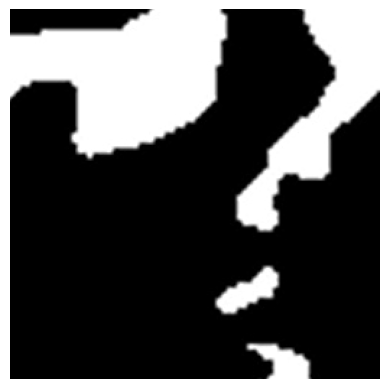

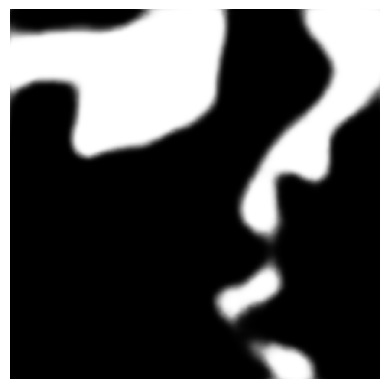

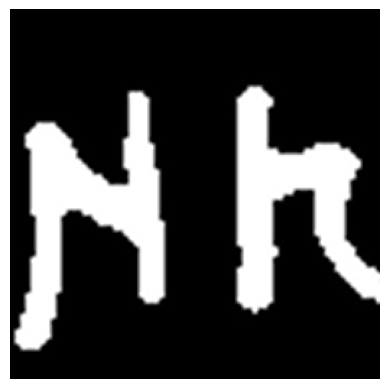

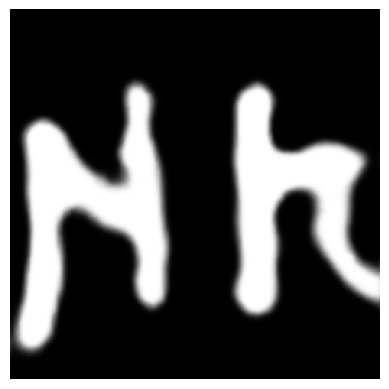

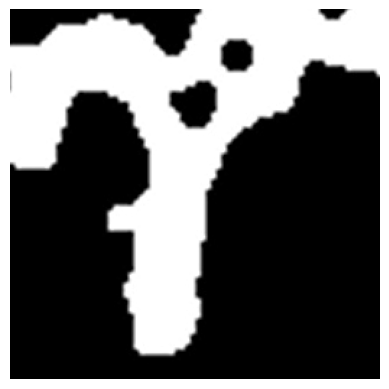

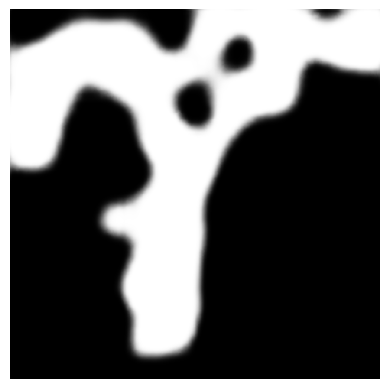

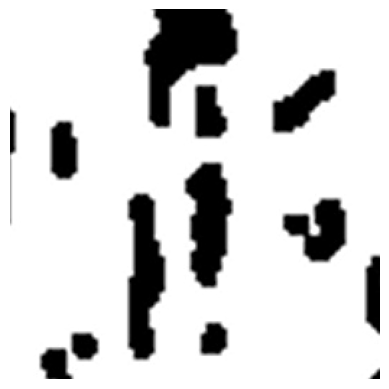

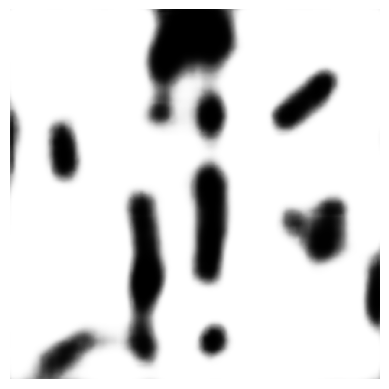

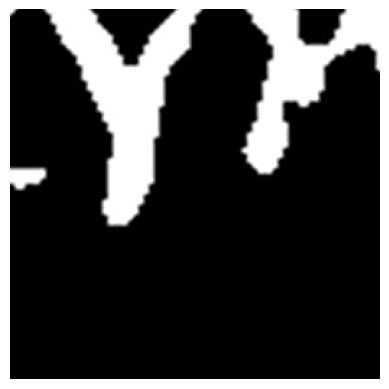

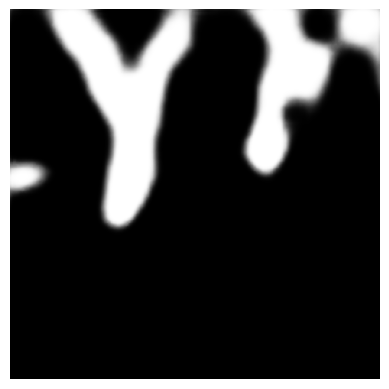

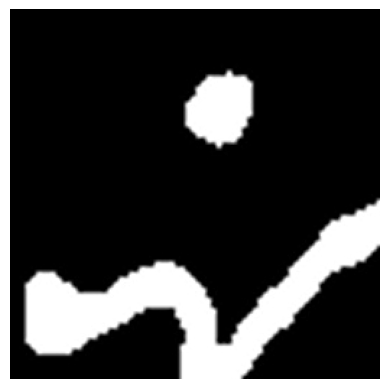

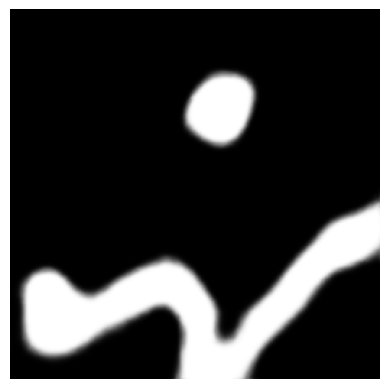

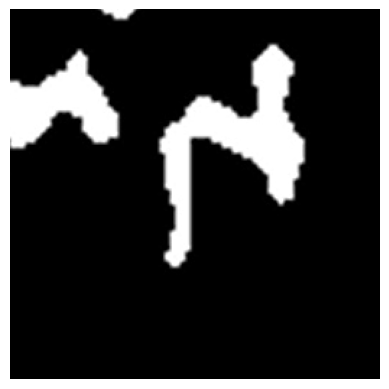

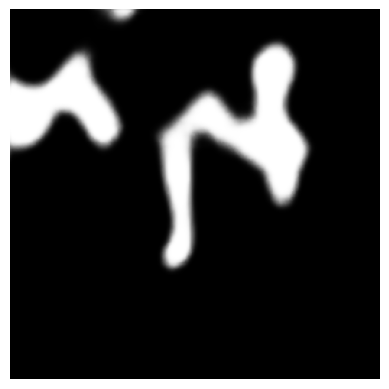

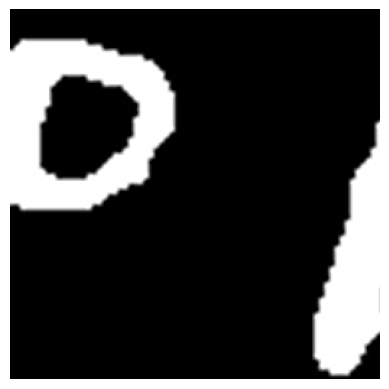

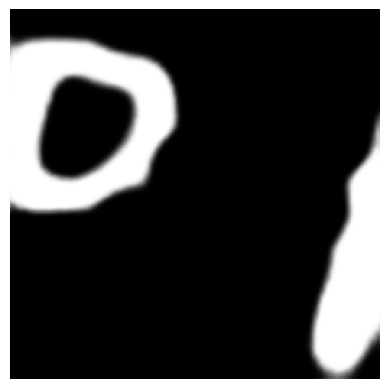

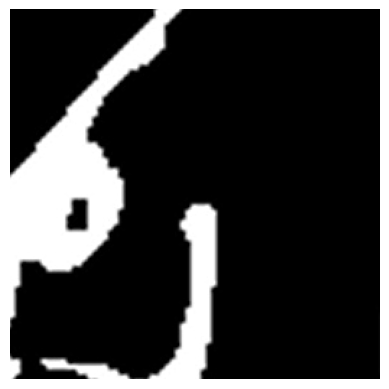

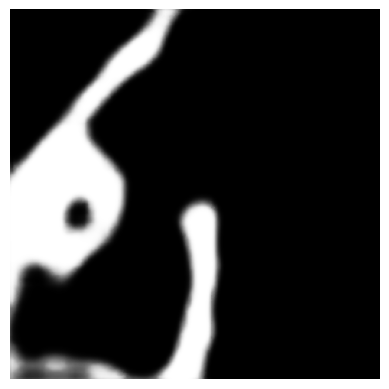

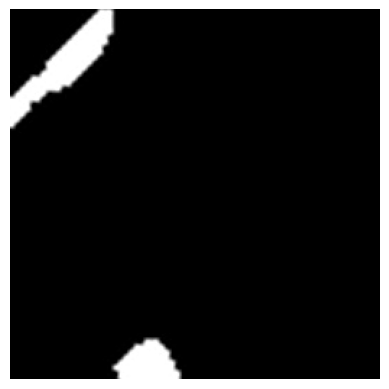

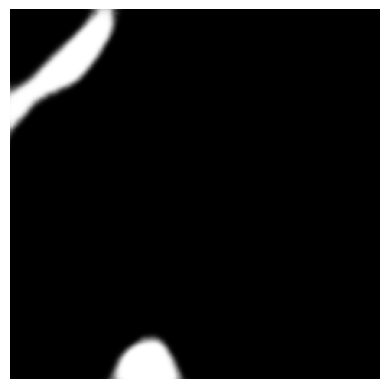

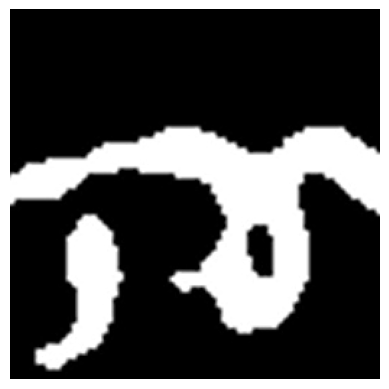

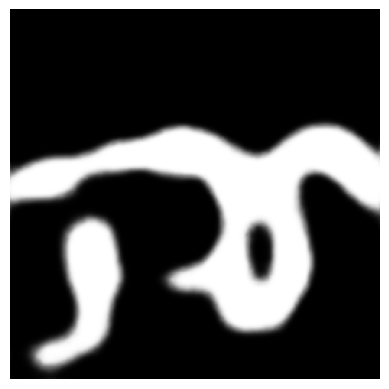

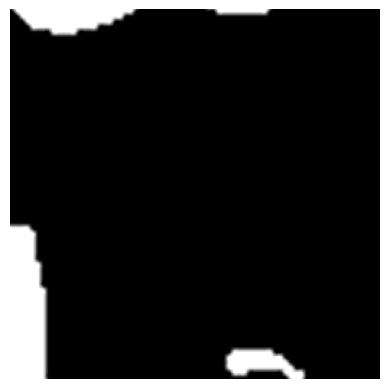

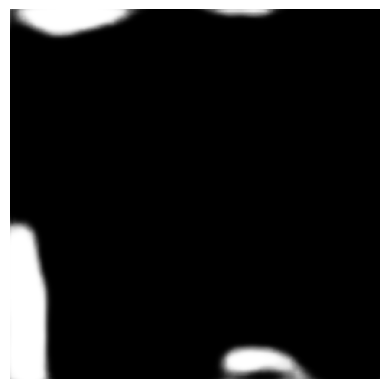

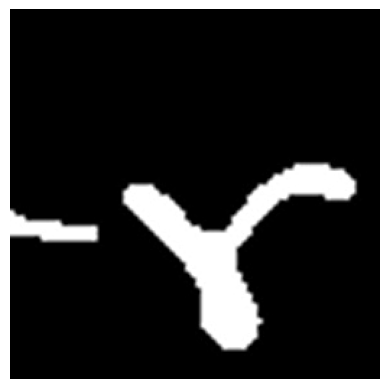

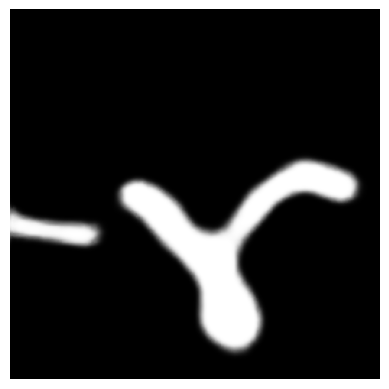

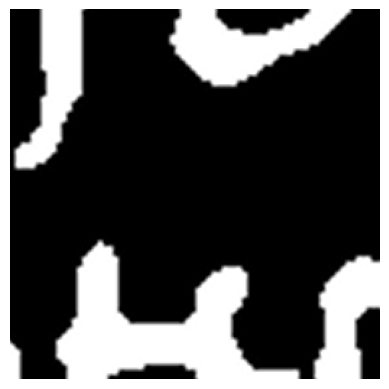

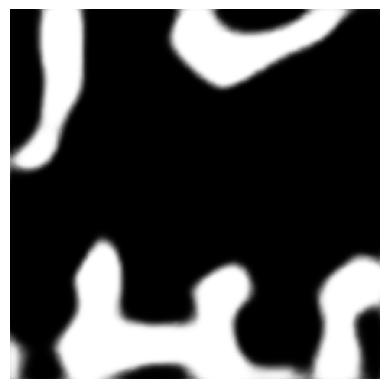

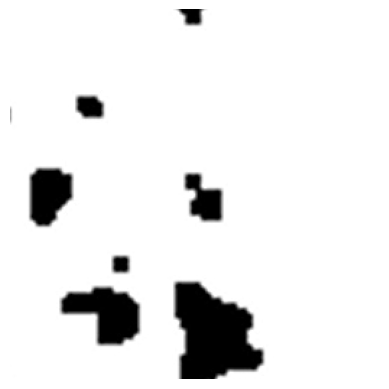

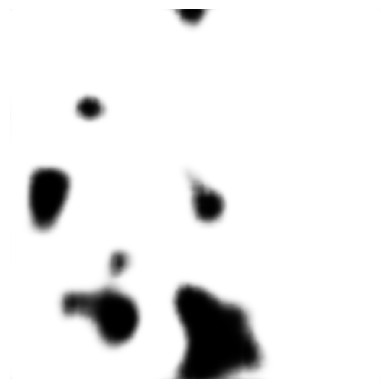

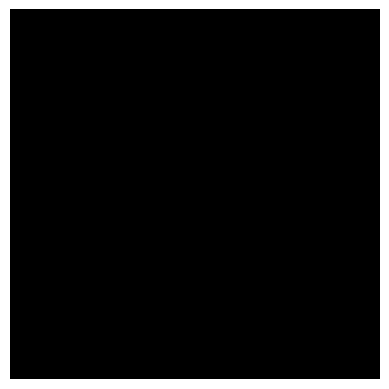

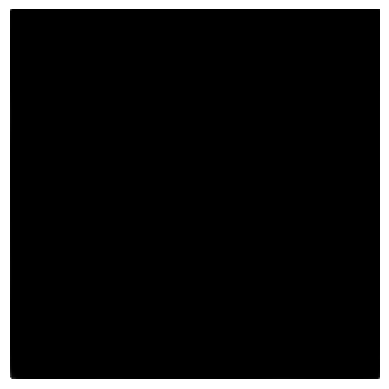

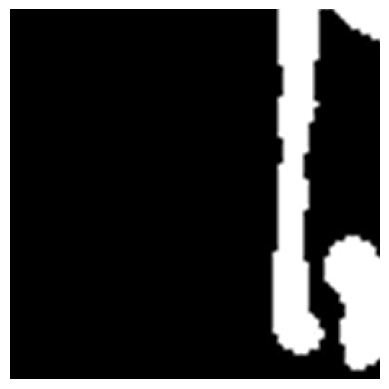

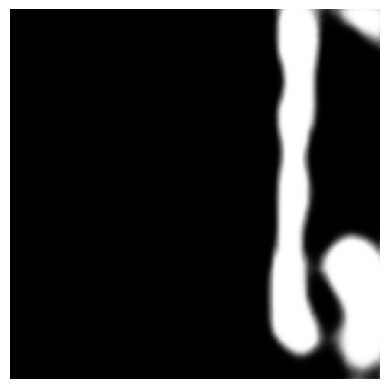

In [76]:
outputs_np = []
for result in results_test:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()